In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import math
from functions.bootstrap_me import meboot
import matplotlib.pyplot as plt
import init_objects
from functions.helpers import organise_data, hypothetical_series, get_specific_bootstraps_moments, confidence_interval
from functions.inequality import gini
from model import *
import statsmodels.api as sm
from matplotlib import style
from functions.evolutionaryalgo import *
import scipy.stats as stats
from SALib.sample import latin
import statsmodels.api as sm
import scipy.stats
from statsmodels.iolib.summary2 import summary_col
import yfinance as yf

In [2]:
style.use('seaborn-ticks')

# Stock market volatility and wealth inequality

1. calibration
2. model dynamics 
3. experiment --> regression 
4. robustness check

## 1 Data

I use the yahoo finance python package to download data on the S&P500. 

In [3]:
tickers = list(pd.read_csv('yahoo_major_indices.csv')['Ticker'])

Remove the VIX index because it it not an equity index and remove the CASE30 because it does not contain any data for the period of interest. 

In [4]:
tickers.remove('^VIX')
tickers.remove('^CASE30')

In [5]:
len(tickers)

33

In [6]:
indices = [yf.Ticker(ticker) for ticker in tickers]
prices = [i.history(start='2019-01-02', end='2019-12-31', interval='1d')['Close'] for i in indices]
returns = [pr.pct_change()[1:] for pr in prices]

Bootstrap the returns series using a maximum entropy bootstrap. 

In [7]:
me_bootstrapped_returns = []
for i in range(len(returns)):
    me_bootstrapped_returns += meboot(returns[i], J=15)
pd.DataFrame(meboot(returns[0], J=2) + meboot(returns[1], J=2)).transpose()

me_bootstrapped_returns = pd.DataFrame(me_bootstrapped_returns).transpose()

In [8]:
len(me_bootstrapped_returns.columns)

495

Calculate the moments of interest.

In [11]:
rets_std = []
rets_autocor = []
rets_avs = []

for rets in me_bootstrapped_returns:
    rets_avs.append(me_bootstrapped_returns[rets].mean())
    rets_std.append(me_bootstrapped_returns[rets].std())
    rets_autocor.append(autocorrelation_returns(me_bootstrapped_returns[rets], 25))

### 1.1 Descriptives

In [14]:
baseline_descriptives = pd.DataFrame({
    'average': [np.mean(rets_avs), np.std(rets_avs), min(rets_avs), np.quantile(rets_avs, q=0.25), 
                np.quantile(rets_avs, q=0.5), np.quantile(rets_avs, q=0.75), max(rets_avs)],
    'standard_deviation': [np.mean(rets_std), np.std(rets_std), min(rets_std), np.quantile(rets_std, q=0.25), 
                np.quantile(rets_std, q=0.5), np.quantile(rets_std, q=0.75), max(rets_std)],
    'autocorrelation': [np.mean(rets_autocor), np.std(rets_autocor), min(rets_autocor), np.quantile(rets_autocor, q=0.25), 
                np.quantile(rets_autocor, q=0.5), np.quantile(rets_autocor, q=0.75), max(rets_autocor)]
}).transpose()
baseline_descriptives.columns = ['average', 'standard deviation', 'min', '25%', '50%', '75%', 'max']

In [15]:
baseline_descriptives.transpose()

,average,standard_deviation,autocorrelation
average,0.000763,0.008749,-0.010438
standard deviation,0.000728,0.004769,0.007869
min,-0.001335,0.004121,-0.023402
25%,0.000301,0.006875,-0.015878
50%,0.000743,0.007826,-0.013295
75%,0.001195,0.009093,-0.006421
max,0.004554,0.043733,0.021490


### 1.2 Calculate confidence intervals 

In [22]:
print('average ', confidence_interval(rets_avs, np.mean(rets_avs)))
print('stdev', confidence_interval(rets_std, np.mean(rets_std)))
print('autocorrelation', confidence_interval(rets_autocor, np.mean(rets_autocor)))

average  (0.0006955368900727955, 0.0008306705618628628)
stdev (0.008306868751317746, 0.009191755987213574)
autocorrelation (-0.011167913941159402, -0.009708034650799415)


In [23]:
confidence_intervals = [confidence_interval(rets_std, np.mean(rets_std)), confidence_interval(rets_autocor, np.mean(rets_autocor))]

In [24]:
confidence_intervals

[(0.008306868751317746, 0.009191755987213574),
 (-0.011167913941159402, -0.009708034650799415)]

### 1.3 How is the data distributed

**Standard deviation of returns**

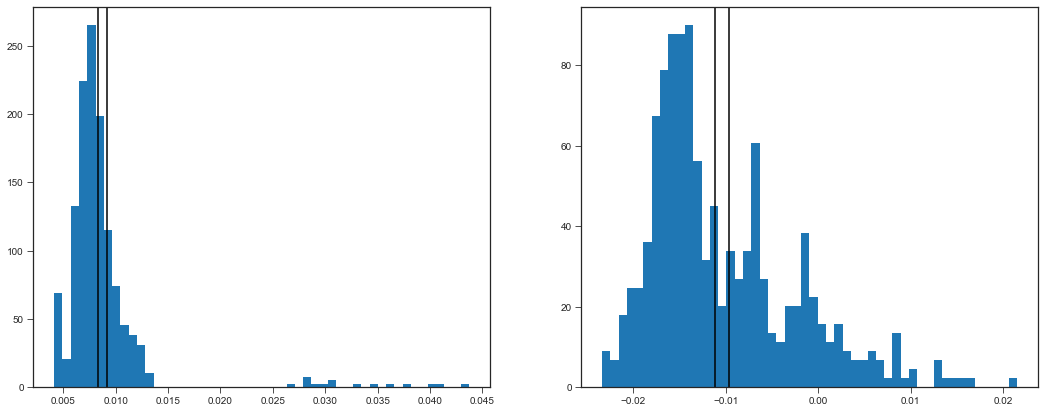

In [33]:
num_bins = 50

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))

# the histogram of the standard deviation of returns
n, bins, patches = ax1.hist(rets_std, num_bins, density=1)
for c in confidence_intervals[0]:
    ax1.axvline(c, color='k')

# the histogram of the autocorrelation of returns
n1, bins1, patches1 = ax2.hist(rets_autocor, num_bins, density=1)
for c in confidence_intervals[1]:
    ax2.axvline(c, color='k')


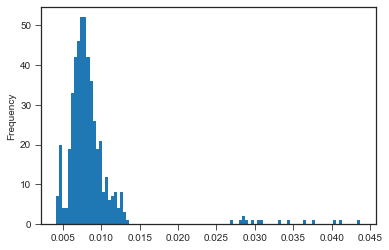

In [18]:
pd.Series(rets_std).plot.hist(bins=100)

In [19]:
print('P-value = ', scipy.stats.shapiro(rets_std)[1])
print('Data has a normal distribution? ', not scipy.stats.shapiro(rets_std)[1] < 0.05)

P-value =  4.115053016526397e-35
Data has a normal distribution?  False


**Autocorrelation of returns**

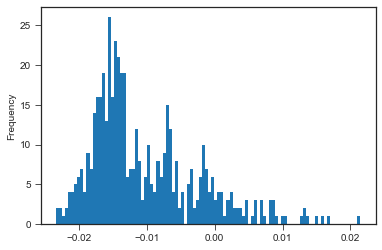

In [20]:
pd.Series(rets_autocor).plot.hist(bins=100)

In [21]:
print('P-value = ', scipy.stats.shapiro(rets_autocor)[1])
print('Data has a normal distribution? ', not scipy.stats.shapiro(rets_autocor)[1] < 0.05)

P-value =  7.162403664072773e-16
Data has a normal distribution?  False


## 2 Calibration

In [66]:
params = {
    "n_traders": 20, # selected for comp efficiency / tractability
    "init_stocks": 100, # selected for comp efficiency / tractability
    "ticks": int(np.mean([len(i) for i in prices]) * 1.25), # average lenght of data
    "init_price": np.mean([np.mean(i) for i in prices]), # average value of reference data
    "white_noise": np.mean(rets_std), # this value will be estimated, but for now it is the average value
         }

In [67]:
params

{'n_traders': 20,
 'init_stocks': 100,
 'ticks': 302,
 'init_price': 13477.214092158467,
 'white_noise': 0.00874931236926566}

Next, I estimate the uncertain parameters using the Method of Simulated moments.There are two moments that I aim to match. These are (1) the standard deviation of returns (because this is the variable of primary interest) and (2) the autocorrelation of returns, which should be close to zero to indicate that prices are not predictable. 

In [73]:
emp_moments = np.array([
    np.mean(rets_std),
    np.mean(rets_autocor),
    ])
emp_moments

array([ 0.00874931, -0.01043797])

To account for the fact that some of these moments might correlate over different Monte Carlo Simulations, the MSM seeks to obtain a variance covariance matrix of the moments. Since there is only one empirical reality, I use a bootstrap procedure to create a covariance matrix of empirical moments. For this, I use a block bootstrap procedure.

In [74]:
all_bootstrapped_moments = [
                            rets_std,
                            rets_autocor
                           ]

In [75]:
av_moments = [np.nanmean(x) for x in all_bootstrapped_moments]
moments_b = [get_specific_bootstraps_moments(all_bootstrapped_moments, n) for n in range(len(me_bootstrapped_returns))]

Here, I follow [Franke & Westerhoff 2016](https://link.springer.com/article/10.1007/s11403-014-0140-6#Sec8) in that I use the inverse of the bootstrap estimate of the moment covariance matrix as my weights.

In [76]:
W_hat = 1.0 / len(me_bootstrapped_returns) * sum([np.dot(np.array([(mb - av_moments)]).transpose(), np.array([(mb - av_moments)])) for mb in moments_b])
W = np.linalg.inv(W_hat)
np.save('distr_weighting_matrix', W)

I establish confidence intervals for the moments.

In [44]:
#confidence_intervals = [confidence_interval(m, emp) for m, emp in zip(all_bootstrapped_moments, emp_moments)]

In [51]:
#confidence_interval_rets_av = confidence_interval(rets_avs, p_returns.mean())

In [53]:
#stats.t.interval(0.95, len(rets_avs) - 1, loc=np.mean(rets_avs), scale=stats.sem(rets_avs))

0.0011048002600096871

In [52]:
#confidence_interval_rets_av

(0.0010173993216920113, 0.001192201198327363)

To start the estimation procedure, I define a problem for the sensitivity analysis and export the starting value, the empirical standard deviation of returns in a txt file. 

In [77]:
problem = {
  'num_vars': 1,
  'names': ['white_noise'],
  'bounds': [[emp_moments[0] * 0.1, emp_moments[0] * 10]]
}
problem

{'num_vars': 1,
 'names': ['white_noise'],
 'bounds': [[0.0008749312369265661, 0.0874931236926566]]}

In [237]:
with open('starting_param.txt', 'w') as f:
    json.dump([[emp_moments[0]]], f)

I perform the estimation excercise in a different Python file using multi-processing. I import the estimate white noise parameter back into the Notebook.

In [78]:
with open('estimated_params.json', 'r') as f:
    est_params = json.loads(f.read())

In [155]:
for i, name in enumerate(problem['names']):
    params[name] = est_params[i]

In [156]:
params

{'n_traders': 20,
 'init_stocks': 100,
 'ticks': 302,
 'init_price': 13477.214092158467,
 'white_noise': 0.03187320252377715}

## 2 Baseline simulations
With the parameters being calibrated, the baseline simulations can be performed. 

In [120]:
NRUNS = 495

In [121]:
trdrs = []
orbs = []
for seed in range(NRUNS):
    traders, orderbook = init_objects.init_objects_model(params, seed)
    traders, orderbook = volatility_inequality_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11
Start of simulation  12
Start of simulation  13
Start of simulation  14
Start of simulation  15
Start of simulation  16
Start of simulation  17
Start of simulation  18
Start of simulation  19
Start of simulation  20
Start of simulation  21
Start of simulation  22
Start of simulation  23
Start of simulation  24
Start of simulation  25
Start of simulation  26
Start of simulation  27
Start of simulation  28
Start of simulation  29
Start of simulation  30
Start of simulation  31
Start of simulation  32
Start of simulation  33
Start of simulation  34
Start of simulation  35
Start of simulation  36
Start of simulation  37
Start of simulation  38
Start of simulation  39
Start of simulation  40
Start of simulation  41
St

Start of simulation  333
Start of simulation  334
Start of simulation  335
Start of simulation  336
Start of simulation  337
Start of simulation  338
Start of simulation  339
Start of simulation  340
Start of simulation  341
Start of simulation  342
Start of simulation  343
Start of simulation  344
Start of simulation  345
Start of simulation  346
Start of simulation  347
Start of simulation  348
Start of simulation  349
Start of simulation  350
Start of simulation  351
Start of simulation  352
Start of simulation  353
Start of simulation  354
Start of simulation  355
Start of simulation  356
Start of simulation  357
Start of simulation  358
Start of simulation  359
Start of simulation  360
Start of simulation  361
Start of simulation  362
Start of simulation  363
Start of simulation  364
Start of simulation  365
Start of simulation  366
Start of simulation  367
Start of simulation  368
Start of simulation  369
Start of simulation  370
Start of simulation  371
Start of simulation  372


### 2.1 Dynamics 

#### 2.1.1 Price, returns & volume 
First, I observe the baseilne dynamics of the price and volume of the risky asset. 

In [122]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume = organise_data(orbs, burn_in_period=(2+60))

In [123]:
lower_autocorr = []
upper_autocorr = []
for row in range(len(mc_autocorr_returns)):
    autocor_range = mc_autocorr_returns.iloc[row]
    lower, upper = confidence_interval(autocor_range, np.mean(autocor_range))
    lower_autocorr.append(lower)
    upper_autocorr.append(upper)

In [124]:
lower_c_price = []
upper_c_price = []
for row in range(len(mc_prices)):
    price_range = mc_prices.iloc[row]
    lower, upper = confidence_interval(price_range, np.mean(price_range))
    lower_c_price.append(max(lower, 0.0))
    upper_c_price.append(upper)

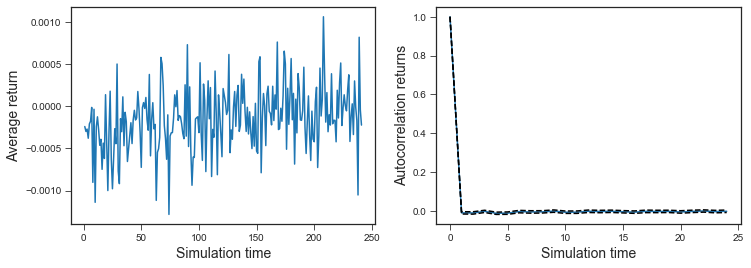

In [158]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

# ax1.plot(mc_prices.index, mc_prices.mean(axis=1), 'k')
# ax1.plot(mc_prices.index[:], lower_c_price, 'k--')
# ax1.plot(mc_prices.index[:], upper_c_price, 'k--')
# ax1.set_ylabel('Price', fontsize='14')

# ax2.bar(mc_volume.index, mc_volume.mean(axis=1), width=1.0, color='black')
# ax2.set_ylabel('Average volume', fontsize='14')

ax1.plot(mc_returns.index, mc_returns.mean(axis=1))
ax1.set_ylabel('Average return', fontsize='14')

ax2.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1))
ax2.plot(mc_autocorr_returns.index, lower_autocorr, 'k--')
ax2.plot(mc_autocorr_returns.index, upper_autocorr, 'k--')
ax2.set_ylabel('Autocorrelation returns', fontsize='14')


for ax in (ax1, ax2):
    ax.set_xlabel('Simulation time', fontsize='14')
    
fig.savefig('baseline_dynamics_ineq.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

Next, here are some key statistics: 

In [126]:
lower_c_vol = []
upper_c_vol = []
for row in range(len(mc_volume)):
    vol_range = mc_volume.iloc[row]
    lower, upper = confidence_interval(vol_range, np.mean(vol_range))
    lower_c_vol.append(max(lower, 0.0))
    upper_c_vol.append(upper)

In [127]:
lower_c_ret = []
upper_c_ret = []
for row in range(len(mc_returns[:-1])): # do not count the first return, because it is nan
    return_range = mc_returns.iloc[row+1]
    lower, upper = confidence_interval(return_range, np.mean(return_range))
    lower_c_ret.append(lower)
    upper_c_ret.append(upper)

In [128]:
baseline_descriptives = pd.DataFrame({
    'prices': [mc_prices.mean().mean(), np.mean(lower_c_price), np.mean(upper_c_price), mc_prices.mean().std()],
    'returns': [mc_returns.mean().mean(), np.mean(lower_c_ret), np.mean(upper_c_ret), mc_returns.mean().std()],
    'volume': [mc_volume.mean().mean(), np.mean(lower_c_vol), np.mean(upper_c_vol), mc_volume.mean().std()]
}).transpose()
baseline_descriptives.columns = ['average', 'lower band', 'upper band', 'standard deviation']

In [129]:
baseline_descriptives.round(decimals=5)

,average,lower band,upper band,standard deviation
prices,12783.83651,12593.76030,12973.91272,1986.37055
returns,-0.00015,-0.00091,0.00061,0.00046
volume,405.49900,391.71813,419.27986,51.78405


### Realism of the simulated data

In [153]:
autocor_rets_sim = [autocorrelation_returns(mc_returns[col], 25) for col in mc_returns]

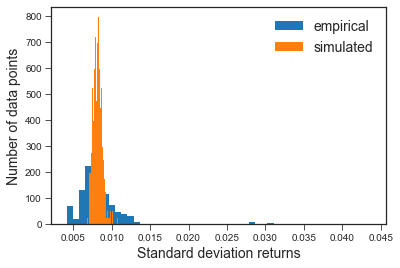

In [163]:
num_bins = 50

fig, ax1 = plt.subplots(1, 1, figsize=(6,4))

# the histogram of the data
n1, bins1, patches1 = ax1.hist(rets_std[:], num_bins, density=1, label='empirical')
n2, bins2, patches2 = ax1.hist(mc_returns.std(), num_bins, density=1, label='simulated')
ax1.set_ylabel('Number of data points', fontsize='14')

# n3, bins3, patches3 = ax2.hist(rets_autocor, num_bins, density=1, label='empirical')
# n4, bins4, patches4 = ax2.hist(autocor_rets_sim, num_bins, density=1, label='simulated')
# ax2.set_ylabel('Autocorrelation returns', fontsize='14')

#for ax in (ax1):
ax1.set_xlabel('Standard deviation returns', fontsize='14')
ax1.legend(loc='best', fontsize='14') 


    
fig.savefig('return_moment_distribution.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [164]:
scipy.stats.shapiro(rets_std)

(0.4968567490577698, 4.115053016526397e-35)

First, I compare the **standard deviation of returns**. 

**Mann-whitneyU**

In [131]:
len(rets_std[:50])
scipy.stats.mannwhitneyu(mc_returns.std(), pd.Series(rets_std[:50]), alternative='two-sided')

MannwhitneyuResult(statistic=12459.0, pvalue=0.9372830000151586)

**Kolmogorov-Smirnov**

In [132]:
test_stat = scipy.stats.ks_2samp(mc_returns.std(), pd.Series(rets_std[:50]))
test_stat

Ks_2sampResult(statistic=0.21919191919191927, pvalue=0.02130275447662033)

Then, I compare the **autocorrelation of returns**

**Mann-whitneyU**

In [135]:
len(rets_std[:50])
scipy.stats.mannwhitneyu(autocor_rets_sim, pd.Series(rets_autocor), alternative='two-sided')

MannwhitneyuResult(statistic=159641.0, pvalue=1.5352856688165694e-16)

**Kolmogorov-Smirnov**

In [136]:
test_stat = scipy.stats.ks_2samp(autocor_rets_sim, pd.Series(rets_autocor))
test_stat

Ks_2sampResult(statistic=0.2727272727272727, pvalue=1.1269607176186774e-16)

In [258]:
len(list(mc_returns.std()))

50

In [112]:
counter_std = 0
for st in mc_returns.std():
    if float(st) > confidence_intervals[0][0] and float(st) < confidence_intervals[0][1]:
        counter_std +=1

In [113]:
counter_std

49

In [114]:
print('empirical stdev return', emp_moments[0]) 
print('confidence interval stdev returns', confidence_intervals[0])
print('average simulated value', mc_returns.mean().mean()) #
print('MCR', counter_std / NRUNS)

empirical stdev return 0.00888387767824725
confidence interval stdev returns (0.006982445997610307, 0.010785309358884193)
average simulated value -0.0003938929240095677
MCR 0.98


In [116]:
counter_autocor = 0
for ac in autocor_rets_sim:
    if float(ac) > confidence_intervals[1][0] and float(ac) < confidence_intervals[1][1]:
        counter_autocor +=1

#### Realism actual data
To test for the realism the data, I perform a Kolmogorov-Smirnov test with the null hypothesis that the two distributions are identical.

Which means that at p-value of bigger than 0.05, we cannot reject the null hypothesis that the two distributions are identical.

In [177]:
test_stat = scipy.stats.kstest(autocor_rets_sim, 'norm')
test_stat

KstestResult(statistic=0.4920770721300604, pvalue=1.0760024343035992e-11)

In [137]:
#If the P-Value of the Shapiro Wilk Test is larger than 0.05, we assume a normal distribution

scipy.stats.shapiro(autocor_rets_sim)

(0.921468198299408, 0.0026654463727027178)

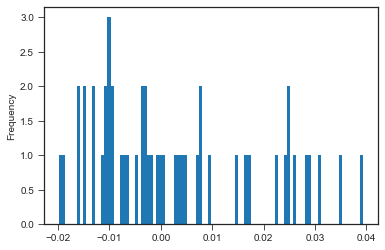

In [133]:
pd.Series(autocor_rets_sim).plot.hist(by=None, bins=100)

In [123]:
# calculate MCR for indices 
counter_std_e = 0
for st in rets_std:
    if float(st) > confidence_intervals[0][0] and float(st) < confidence_intervals[0][1]:
        counter_std_e +=1

In [122]:
counter_autocore = 0
for ac in rets_autocor:
    if float(ac) > confidence_intervals[1][0] and float(ac) < confidence_intervals[1][1]:
        counter_autocore +=1

Performance

In [125]:
print('empirical autocorrelation return', emp_moments[1])
print('confidence interval stdev returns', confidence_intervals[1])
print('average simulated value', np.mean(autocor_rets_sim)) #
print('MCR', counter_autocor / NRUNS)
print('MCR_emp', counter_autocore / len(tickers))

empirical autocorrelation return -0.009520189063771809
confidence interval stdev returns (-0.012391149230720195, -0.006649228896823423)
average simulated value 0.002589864476206105
MCR 0.22
MCR_emp 0.21212121212121213


#### 2.1.2 Correlation of (log) returns, and (log) wealth.

First, I calculate the (log) wealth of all agents in time and the (log) returns they had on their portfolio in the subsequent period. 

In [165]:
portfolios = {}
long_list_portfolios = {'wealth': [], 'log_wealth': [], 'returns': [], 'log_returns':[], 'period':[], 'agent_id': []}

for seed in range(NRUNS):
    for p_idx, portf in enumerate(trdrs[seed]):
        value_over_time = []
        log_value_over_time = []
        returns_over_time = []
        log_returns_over_time = []
        periods = []
        agent = []
        
        for t in range(params["ticks"] - 1):
            v0 = portf.var.wealth[t]
            value_over_time.append(v0)
            log_value_over_time.append(np.log(v0))
            
            v1 = portf.var.wealth[t+1]
            returns_over_time.append(((v1 - v0) / v0))
            log_returns_over_time.append(np.log(v1/v0))
            
            periods.append(t)
            agent.append(str(p_idx) + '_' + str(seed))

        portfolios['value_{}_seed_{}'.format(p_idx, seed)] = value_over_time
        portfolios['log_value_{}_seed_{}'.format(p_idx, seed)] = log_value_over_time
        portfolios['return+1_{}_seed_{}'.format(p_idx, seed)] = returns_over_time
        portfolios['log_return+1_{}_seed_{}'.format(p_idx, seed)] = log_returns_over_time
        
        
        long_list_portfolios['period'] += periods
        long_list_portfolios['agent_id'] += agent#str(seed) + '_' + str(agent)
        
        long_list_portfolios['wealth'] += value_over_time
        long_list_portfolios['log_wealth'] += log_value_over_time
        long_list_portfolios['returns'] += returns_over_time
        long_list_portfolios['log_returns'] += log_returns_over_time

In [166]:
wealth_returns = pd.DataFrame(long_list_portfolios)

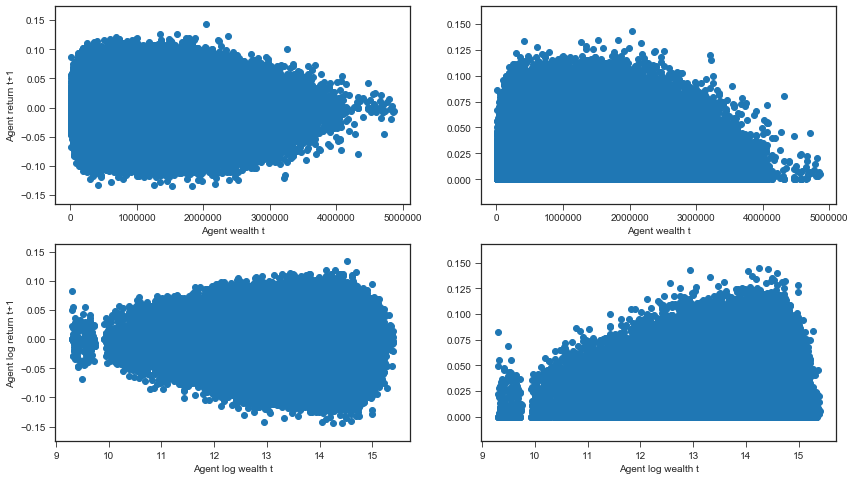

In [167]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14,8))

ax1.scatter(wealth_returns['wealth'], wealth_returns['returns'])#, color='k')
ax1.set_xlabel('Agent wealth t')
ax1.set_ylabel('Agent return t+1')

ax2.scatter(wealth_returns['wealth'], wealth_returns['returns'].abs())#, color='k')
ax2.set_xlabel('Agent wealth t')

ax3.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'])#, color='k')
ax3.set_xlabel('Agent log wealth t')
ax3.set_ylabel('Agent log return t+1')

ax4.scatter(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs())#, color='k')
ax4.set_xlabel('Agent log wealth t')

fig.savefig('wealth_return_scatter.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [60]:
wealth_returns.head()

,wealth,log_wealth,returns,log_returns,period,agent_id
0,17392.569191,9.763798,0.000000,0.000000,0,0_0
1,17392.569191,9.763798,0.028221,0.027830,1,0_0
2,17883.400083,9.791628,-0.070549,-0.073161,2,0_0
3,16621.752774,9.718468,0.000000,0.000000,3,0_0
4,16621.752774,9.718468,0.000000,0.000000,4,0_0


In [168]:
print('wealth / returns')
print('pearson', scipy.stats.pearsonr(wealth_returns['wealth'], wealth_returns['returns']))
print(scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns']))

print('wealth / abs rets')
print('pearson', scipy.stats.pearsonr(wealth_returns['wealth'], wealth_returns['returns'].abs()))
print(scipy.stats.spearmanr(wealth_returns['wealth'], wealth_returns['returns'].abs()))

print('log wealth / log rets')
print('pearson' ,scipy.stats.pearsonr(wealth_returns['log_wealth'], wealth_returns['log_returns']))
print(scipy.stats.spearmanr(wealth_returns['log_wealth'], wealth_returns['log_returns']))
print('log wealth / log rets abs')
print('pearson', scipy.stats.pearsonr(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs()))
print(scipy.stats.spearmanr(wealth_returns['log_wealth'], wealth_returns['log_returns'].abs()))

wealth / returns
pearson (-0.010874293782499508, 1.275578194327779e-78)
SpearmanrResult(correlation=0.0004194530540228164, pvalue=0.46901919037197326)
wealth / abs rets
pearson (-0.0005596134485812808, 0.3340311437876603)
SpearmanrResult(correlation=0.018429423488726428, pvalue=3.855674469362324e-222)
log wealth / log rets
pearson (-0.008042823502974413, 7.914076127127238e-44)
SpearmanrResult(correlation=0.0004194530540228164, pvalue=0.46901919037197326)
log wealth / log rets abs
pearson (0.0013309191890212059, 0.021591160800580943)
SpearmanrResult(correlation=0.018455207694414933, pvalue=9.33015018838221e-223)


#### 2.1.3 Evolution of inequality
Gini, Palma, & individual wealth. 

In [169]:
best_traders = list(wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=False).iloc[0:10]['agent_id'])
worst_traders = list(wealth_returns[wealth_returns['period'] == params['ticks']-2].sort_values(by=['wealth'], ascending=True).iloc[0:10]['agent_id'])

Calculate Gini and Palma ratio's of wealth over time.

In [170]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
returns = []
absolute_returns = []
market_returns = []

returns_ot = []
wealth_ot = []
log_returns_ot = []
log_wealth_ot = []

# determine the start and end wealth
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # returns
    returns.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    absolute_returns.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    wealth_gini_over_time = []
    palma_over_time = []
    
    wealth_over_time = []
    returns_over_time = []
    log_returns_over_time = []
    log_wealth_over_time = []
    for t in range(params["ticks"]):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        wealth_gini_over_time.append(gini(wealth))
        
        for a in range(len(traders)):
            wealth_over_time.append(wealth[a])
            log_wealth_over_time.append(np.log(wealth[a]))

            if t > 0:
                returns_over_time.append((wealth_over_time[t] - wealth_over_time[t-1]) / wealth_over_time[-1])
                log_returns_over_time.append(np.log(wealth_over_time[t] / wealth_over_time[t-1])) # log returns = log(return + 1)

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    
    returns_ot.append(returns_over_time)
    wealth_ot.append(wealth_over_time)
    log_returns_ot.append(log_returns_over_time)
    log_wealth_ot.append(log_wealth_over_time)

Calculate averages and confidence intervals. 

In [171]:
av_gini_ot = []
low_gini_ot = []
up_gini_ot = []

av_palma_ot = []
low_palma_ot = []
up_palma_ot = []

for t in range(params["ticks"]):
    t_gini = [g[t] for g in ginis_ot]
    av_gini_ot.append(np.mean(t_gini))
    low, up = confidence_interval(t_gini, np.mean(t_gini))
    low_gini_ot.append(low)
    up_gini_ot.append(up)

    t_palma = [p[t] for p in palmas_ot]
    av_palma_ot.append(np.mean(t_palma))
    low, up = confidence_interval(t_palma, np.mean(t_palma))
    low_palma_ot.append(low)
    up_palma_ot.append(up)

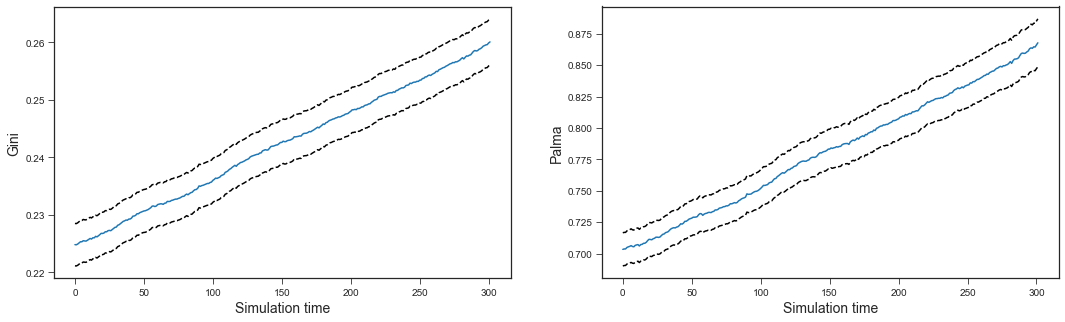

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))


ax1.plot(range(len(av_gini_ot[:])), av_gini_ot[:])#, 'k')
ax1.plot(range(len(low_gini_ot[:])), low_gini_ot[:], 'k--')
ax1.plot(range(len(up_gini_ot[:])), up_gini_ot[:], 'k--')
ax1.set_ylabel('Gini', fontsize='14')

ax2.plot(range(len(av_gini_ot[:])), av_palma_ot[:])#, 'k')
ax2.plot(range(len(low_gini_ot[:])), low_palma_ot[:], 'k--')
ax2.plot(range(len(up_gini_ot[:])), up_palma_ot[:], 'k--')
ax2.set_ylabel('Palma', fontsize='14')

    
for ax in (ax1, ax2, ax3):
    ax.set_xlabel('Simulation time', fontsize='14')
    
fig.savefig('dynamics_of_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

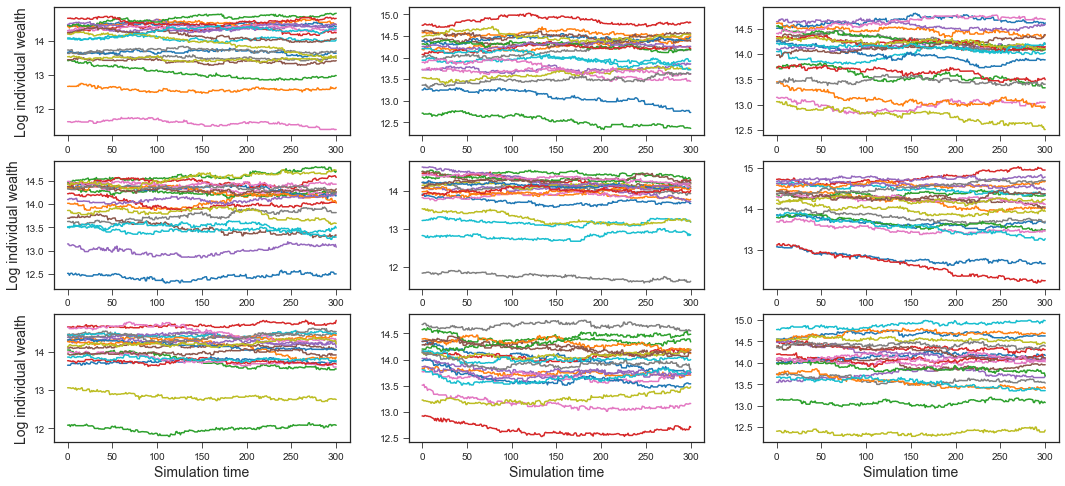

In [173]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(18,8))

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
# depict traders from a random simulation
random_simulations = np.random.randint(0, NRUNS, size=len(axes))

for idx, sim in enumerate(random_simulations):
    for tr in wealth_returns['agent_id'].unique():
        if tr[tr.find('_') + 1:] == str(sim):
            axes[idx].plot(wealth_returns[wealth_returns['agent_id'] == tr]['period'], wealth_returns[wealth_returns['agent_id'] == tr]['log_wealth'])#, 'k')
    if idx in [0, 3, 6]:
        axes[idx].set_ylabel('Log individual wealth', fontsize='14')

for x in [ax7, ax8, ax9]:
    x.set_xlabel('Simulation time', fontsize='14')
    

fig.savefig('inequality_paths.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

# 3 Experiment

In this experiment, I will vary the white noise component 20% around its estimated value in steps of 5%. This will increase the volatility of the price and, should increase, inequality at the end of the simulation. 

In [62]:
params

{'ticks': 614,
 'n_traders': 20,
 'init_stocks': 81,
 'init_price': 1147.8213214905302,
 'white_noise': 0.14210650811222386}

In [46]:
white_noise_range =[((x / 100.0) + 1 ) * params['white_noise'] for x in range(-20, 25, 5)]
white_noise_range

[0.09473767207481591,
 0.10065877657949189,
 0.1065798810841679,
 0.11250098558884387,
 0.11842209009351988,
 0.12434319459819589,
 0.13026429910287188,
 0.13618540360754786,
 0.14210650811222386]

In [47]:
NRUNS = 10
experiments = len(white_noise_range)

In [48]:
trdrs = []
orbs = []

for exp in range(experiments):
    params['white_noise'] = white_noise_range[exp]
    for seed in range(NRUNS): 
        traders, orderbook = init_objects.init_objects_model(params, seed)
        traders, orderbook = volatility_inequality_model(traders, orderbook, params, seed)
        trdrs.append(traders)
        orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of si

In [49]:
full_white_n = []
for exp in range(experiments):
    for seed in range(NRUNS):
        full_white_n.append(white_noise_range[exp])

In [50]:
ginis = []
palmas = []
var_log_returns = []

for idx, traders in enumerate(trdrs):
    wealth_end = np.array([x.var.wealth[-1] for x in trdrs[idx]])
    wealth_start = np.array([x.var.wealth[0] for x in trdrs[idx]])

    share_top_10 = sum(np.sort(wealth_end)[int(len(wealth_end) * 0.9):]) / sum(wealth_end)
    share_bottom_40 = sum(np.sort(wealth_end)[:int(len(wealth_end) * 0.4)]) / sum(wealth_end)
    palmas.append(share_top_10 / share_bottom_40)
    
    ginis.append(gini(wealth_end))
    var_log_returns.append(np.std(np.log(np.array(wealth_end) / np.array(wealth_start))))

Collect data on volatility

In [51]:
mc_prices_exp, mc_returns_exp, mc_autocorr_returns_exp, mc_autocorr_abs_returns_exp, mc_volatility_exp, mc_volume_exp = organise_data(orbs, burn_in_period=0)

In [52]:
av_stdev_prices_exp = list(mc_prices_exp.std(axis=0))
av_stdev_returns_exp = list(mc_returns_exp.std(axis=0))

Split the data in parts of NRUNS


In [53]:
gini_averages = []
gini_conf_interval_uppers = []
gini_conf_intervals_lowers = []

palma_averages = []
palma_conf_interval_uppers = []
palma_conf_intervals_lowers = []

pr_averages = []
pr_conf_interval_uppers = []
pr_conf_intervals_lowers = []

vol_averages = []
vol_conf_interval_uppers = []
vol_conf_intervals_lowers = []

for x in range(experiments):
    y = x*NRUNS
    
    g = ginis[y:y+NRUNS]
    gini_averages.append(np.mean(g))
    sample_stdev = np.std(g)
    sigma = sample_stdev/math.sqrt(len(g))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(g), scale = sigma) 
    gini_conf_interval_uppers.append(min(upper, 1.0))
    gini_conf_intervals_lowers.append(lower)
    
    p = palmas[y:y+NRUNS]
    palma_averages.append(np.mean(p))
    sample_stdev = np.std(p)
    sigma = sample_stdev/math.sqrt(len(p))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(p), scale = sigma) 
    palma_conf_interval_uppers.append(upper)
    palma_conf_intervals_lowers.append(max(lower, 0))
    
    pr = var_log_returns[y:y+NRUNS]
    pr_averages.append(np.mean(pr))
    sample_stdev = np.std(pr)
    sigma = sample_stdev/math.sqrt(len(pr))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(pr), scale = sigma) 
    pr_conf_interval_uppers.append(upper)
    pr_conf_intervals_lowers.append(max(lower, 0))
    
    v = av_stdev_prices_exp[y:y+NRUNS]
    vol_averages.append(np.mean(v))
    sample_stdev = np.std(v)
    sigma = sample_stdev/math.sqrt(len(v))
    lower, upper = stats.t.interval(alpha = 0.95, df= 24, loc = np.mean(v), scale = sigma) 
    vol_conf_interval_uppers.append(upper)
    vol_conf_intervals_lowers.append(max(lower, 0))

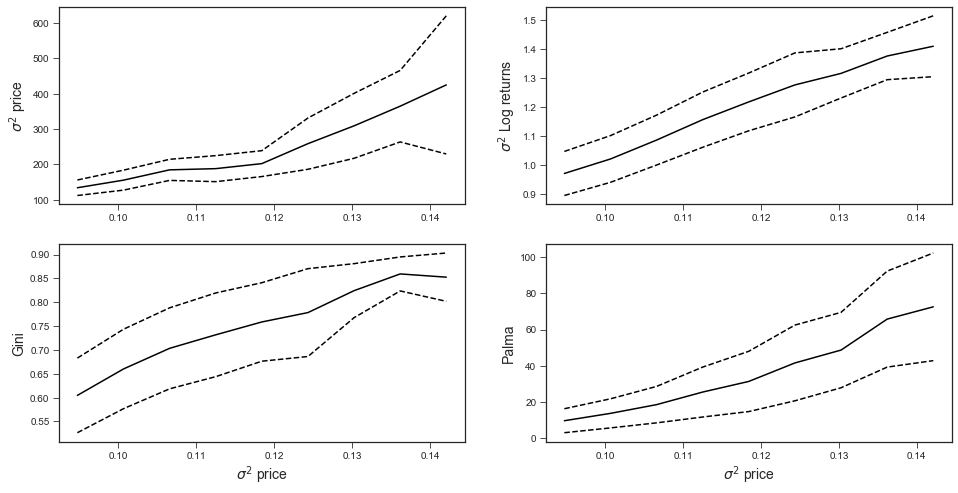

In [54]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[16,8])

ax1.plot(white_noise_range, vol_averages, 'k')
ax1.plot(white_noise_range, vol_conf_interval_uppers, 'k--')
ax1.plot(white_noise_range, vol_conf_intervals_lowers, 'k--')

ax2.plot(white_noise_range, pr_averages, 'k')
ax2.plot(white_noise_range, pr_conf_interval_uppers, 'k--')
ax2.plot(white_noise_range, pr_conf_intervals_lowers, 'k--')

ax3.plot(white_noise_range, gini_averages, 'k')
ax3.plot(white_noise_range, gini_conf_interval_uppers, 'k--')
ax3.plot(white_noise_range, gini_conf_intervals_lowers, 'k--')

ax4.plot(white_noise_range, palma_averages, 'k')
ax4.plot(white_noise_range, palma_conf_interval_uppers, 'k--')
ax4.plot(white_noise_range, palma_conf_intervals_lowers, 'k--')


ax1.set_ylabel('$\sigma^2$ price', fontsize=14)
ax2.set_ylabel('$\sigma^2$ Log returns', fontsize=14)
ax3.set_ylabel('Gini', fontsize=14)
ax4.set_ylabel('Palma', fontsize=14)


for ax in [ax3, ax4]:
    ax.set_xlabel('$\sigma^2$ price', fontsize=14)

fig.savefig('vol_logrets_inequality.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

Next, I will do the following regressions on the data. 

$\Delta Gini = \alpha + \beta \Delta volatility.$

$\Delta Palma = \alpha + \beta \Delta volatility.$

$\Delta Gini = \alpha + \beta \Delta white noise.$

$\Delta Palma = \alpha + \beta \Delta white noise.$

In [55]:
df = pd.DataFrame({'white_noise': full_white_n, 'ginis': ginis, 'stdev_returns': av_stdev_returns_exp,
              'palmas': palmas})
df['const'] = 1

### Regressing stdev of returns (price volatility) 

In [56]:
gini_res_stdev = sm.OLS(endog=df['ginis'], exog=df[['const', 'stdev_returns']], missing='drop').fit()
palma_res_stdev = sm.OLS(endog=df['palmas'], exog=df[['const', 'stdev_returns']], missing='drop').fit()

In [57]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res_stdev, palma_res_stdev],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma'],
                            info_dict=info_dict,
                            regressor_order=['const', 'stdev_returns'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

               Table - OLS Regressions
                        Gini              Palma       
------------------------------------------------------
const            0.1963***          -93.0809***       
                 (0.0378)           (11.2996)         
stdev_returns    12.5030***         2909.9646***      
                 (0.8315)           (248.3544)        
R-squared        0.7198301469029802 0.6093883386760034
No. observations 90                 90                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


### Regressing white noise component expectations 

In [58]:
gini_res = sm.OLS(endog=df['ginis'], exog=df[['const', 'white_noise']], missing='drop').fit()
palma_res = sm.OLS(endog=df['palmas'], exog=df[['const', 'white_noise']], missing='drop').fit()

In [59]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma'],
                            info_dict=info_dict,
                            regressor_order=['const', 'std_exp'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                Table - OLS Regressions
                         Gini              Palma       
-------------------------------------------------------
const            0.1268              -125.1451***      
                 (0.0960)            (24.0401)         
white_noise      5.2839***           1363.8409***      
                 (0.8041)            (201.3327)        
R-squared        0.32917300161426977 0.3427340699227408
No. observations 90                  90                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Text(0, 0.5, 'Gini')

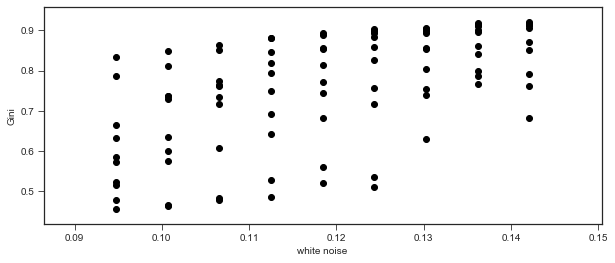

In [61]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,4))

ax1.scatter(df['white_noise'], df['ginis'], color='k')
ax1.set_xlabel('white noise')
ax1.set_ylabel('Gini')

# 4 Use global sensitivity analysis to calcuate confidence intervals